In [188]:
import matplotlib

import glob
from obspy import read
from os.path import join as pj
from os.path import basename

In [189]:
def mseed_paths(waveform_path):
    return glob.glob(pj(waveform_path, 'local/*.mseed'))

In [190]:
from multiprocessing import Pool

def get_time(waveform_path):
    waveform = read(waveform_path)
    return waveform[0].stats.starttime
    
def parallel_times(path):
    mseeds = mseed_paths(path)
    with Pool() as p:
        time_list = p.map(get_time, mseeds)
    return time_list


In [191]:
import pandas as pd

def dataframe(wave_times):
    df = pd.DataFrame({'time': wave_times})
    df["time"] = df["time"].astype("datetime64[ns]")
    return df

In [192]:
def minmag(name):
    return 'minmag' in name

def remove_minmag(name):
    return name.split('-minmag1')[0]

def fix_name(name):
    return remove_minmag(name) if minmag(name) else name
    
def clean(information):
    int_cols = ['Amount Correct Noise', 'Amount Total Noise',  'Amount Correct Local', 'Amount Total Local']
    cols = [ 'Name', 'Amount Correct Noise', 'Amount Total Noise',  'Amount Correct Local', 'Amount Total Local', 'Total Percent Correct']
    information = information[cols]
    information = information.round({'Total Percent Correct': 4})
    
    for col in int_cols:
        information[col] = information[col].astype('int32')

    information['Name'] = information['Name'].apply(fix_name)
    information.drop_duplicates('Name', inplace=True)
    return information

In [197]:
from collections import namedtuple
import os
import numpy as np

InfoTimes = namedtuple('InfoTimes', ('info', 'times'))
    

    
def proper_name(name):
    if '--' not in name:
        name = "--".join(name.split('-'))
        if name.startswith('--'):
            name = name[1:]
    if '--' not in name:
        return name 
    lat, lon = name.split('--')
    lat, lon = float(lat), float(lon)
    new_name = f'{lat:,.2f}N {lon:,.2f}E'
    return new_name


def to_percent(decimal):
    return np.round(decimal * 100, decimals=2)

def Info(name):
    df = information.loc[information['Name'] == name]
    if df.empty:
        raise ValueError("Empty DF: " + name)
        
    df['Name'] = df['Name'].apply(proper_name)
    df['Total Percent Correct'] = df['Total Percent Correct'].apply(to_percent)
    return df  # Panda Series


def fix_column_names(information):
    def fix(name):
        if name == 'Name':
            return 'Location'
        else:
            name = name.split()[1:]
            return " ".join(name)
    
    information.columns = information.columns.to_series().apply(fix)
    return information
    
def info_times(paths):
    for path in paths:
        name = os.path.basename(path)
        time = parallel_times(path)
        time = dataframe(time)
        info = Info(name)
        info = fix_column_names(info)
        yield InfoTimes(info, time)

def valid_paths(paths, keep_paths):
    keep = map(basename, keep_paths)
    keep = set(keep_paths)
    return [path for path in paths if basename(path) in keep]


In [198]:
csv = '/home/audretj/developer-projects/waveforms/notebooks/combine-csv/results-complete.csv'
information = pd.read_csv(csv, index_col=0)
information = clean(information)

waveforms_path = '/home/audretj/developer-projects/waveforms/seismic_toolbox/waveforms'
waveform_paths = glob.glob(pj(waveforms_path, '*'))
waveform_paths = list(set(map(fix_name, waveform_paths)))
waveform_paths = valid_paths(waveform_paths, information['Name'])

In [199]:
times = info_times(waveform_paths)

In [200]:
infotimes = list(times)

/home/audretj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/audretj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [241]:
from matplotlib import pyplot as plt
import datetime
from itertools import islice

def plot_time_freq(df, by='week', xlabels='number', axis_on=True, title=False, **kwargs):
    """
    by: 'week' or 'day' or 'month'
    labels: 'number' or 'date'
    kwargs: passed to dataframe.plot()
    """
    if title:
        kwargs['title'] = f'Event Frequency Per {by.title()}'
    
    if by == 'month':
        frame = df.groupby([df["time"].dt.year, df["time"].dt.month]).count()
    
    elif by == 'week':
        frame = df.groupby([df["time"].dt.year, df["time"].dt.month, df["time"].dt.week]).count()
        
    elif by == 'day':
        frame = df.groupby([df["time"].dt.year, df["time"].dt.month, df["time"].dt.day]).count()
        
    frame = frame.plot(legend=False, **kwargs)
    frame.xaxis.label.set_visible(False)
    
    def labeltimes(num_parts):
        start, end = df.min()[0].to_pydatetime(), df.max()[0].to_pydatetime()
        part = (end - start) / num_parts
        parts = [start + (part * i) for i in range(num_parts)]
        return [dt.strftime('%D') for dt in parts]
    
    def labelnums(num):
        nums = list(range(1, num+1))
        return nums
    
    def set_xlabels(label_type):
        label_len = len([item.get_text() for item in frame.get_xticklabels()])    
        
        if label_type == 'number':
            labels = labelnums(label_len)
            
        elif label_type == 'date':
            labels = labeltimes(label_len)
        
        elif label_type == 'none':
            labels = [' ']  * label_len
    
        frame.set_xticklabels(labels)
        
    if xlabels: 
        set_xlabels(xlabels)
    
    if not axis_on:
        plt.axis('off')

    return frame
    
def plot_table(info):
    dc = info
    table = plt.table(cellText=dc.values, 
              colWidths= [1/len(dc.columns)] * len(dc.columns),
              colLabels=dc.columns.values,
              cellLoc = 'center', 
              rowLoc = 'center')
    
def plot_info_table(info, position='top', scale=(1, 2), collabels=True):
    dc = info
    
    cell_text = dc.values
    cell_text[0][-1] = f'{cell_text[0][-1]:.2f}'
    
    table = plt.table(cellText=cell_text, colWidths= [1/len(dc.columns)] * len(dc.columns),
          #rowLabels=dc.index,
          colLabels=dc.columns.values if collabels else None,
          cellLoc = 'center', rowLoc = 'center',
          loc=position)
    
    table.auto_set_font_size(False)
    table.scale(*scale)  # may help
    
    return table


    
from subprocess import call
def remove_borders(file):
    """
    Removes borders of file
    Must have ImageMagik installed.
    """
    call(["convert", file, "-trim", "+repage", file])


In [242]:
def get_accuracy(infotime):
    return infotime.info['Percent Correct'].values[0]

infotimes = sorted(infotimes, key=get_accuracy, reverse=True)

/home/audretj/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


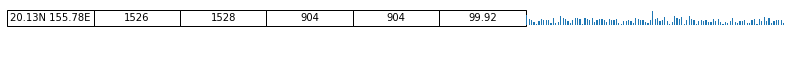

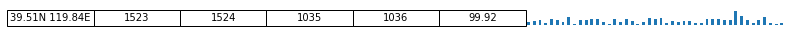

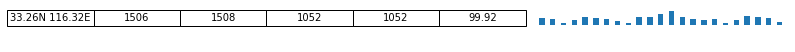

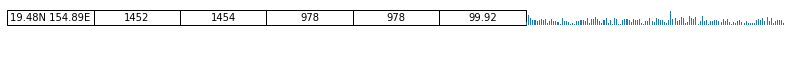

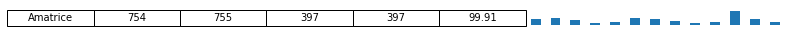

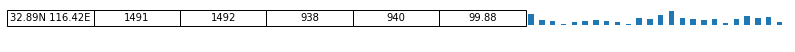

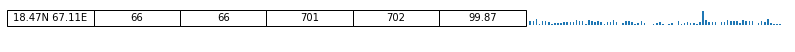

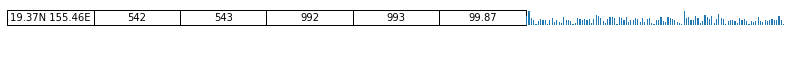

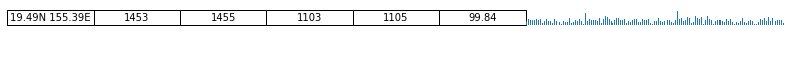

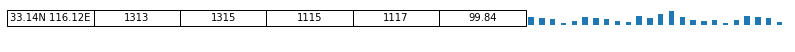

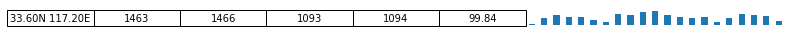

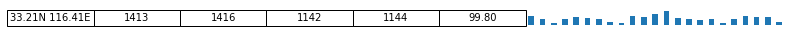

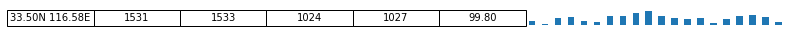

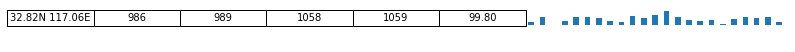

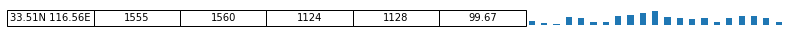

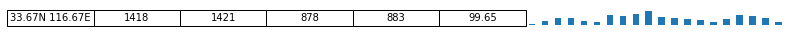

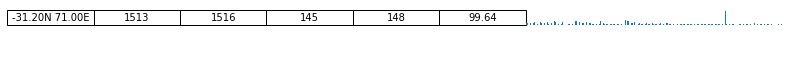

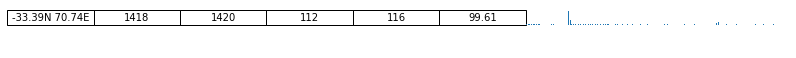

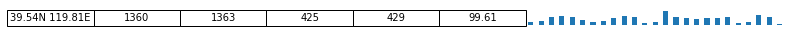

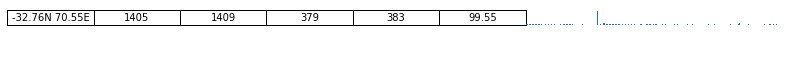

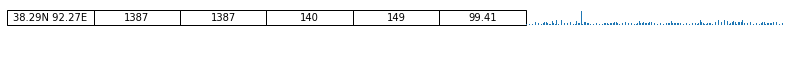

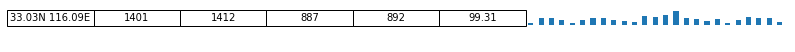

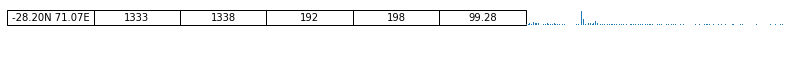

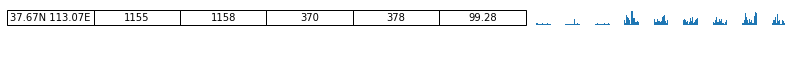

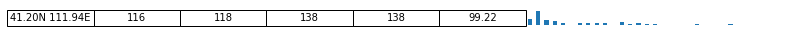

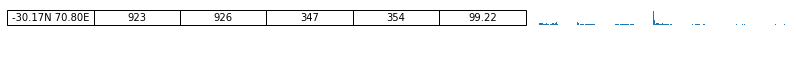

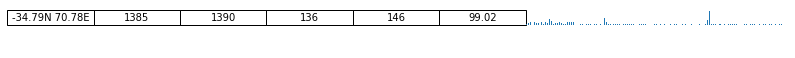

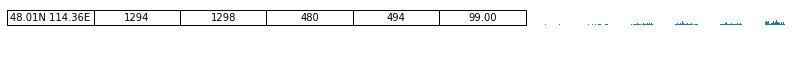

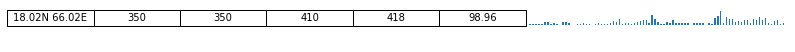

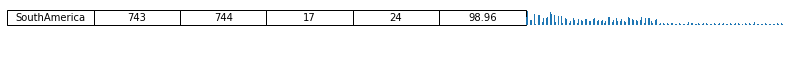

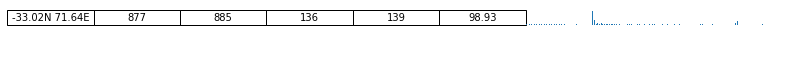

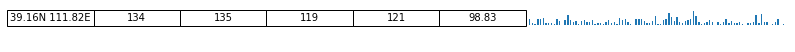

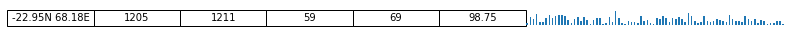

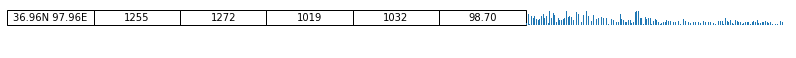

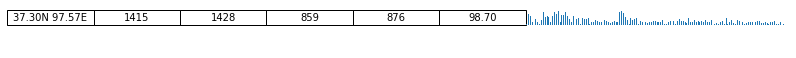

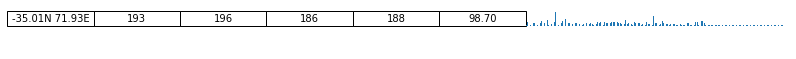

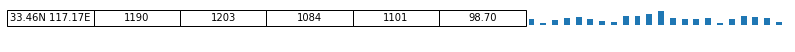

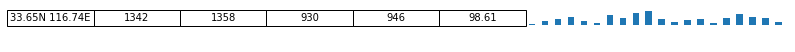

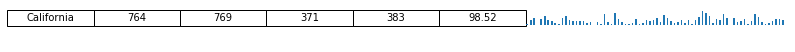

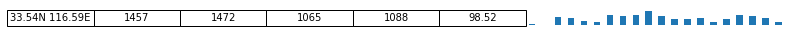

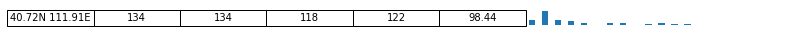

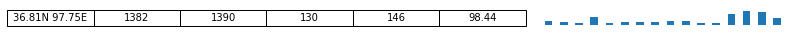

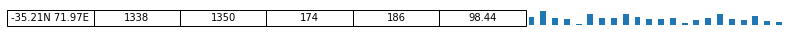

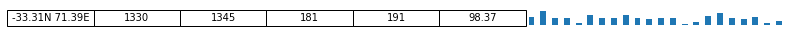

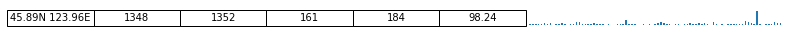

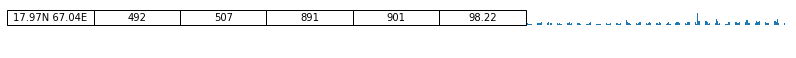

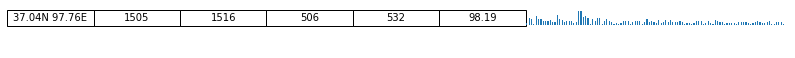

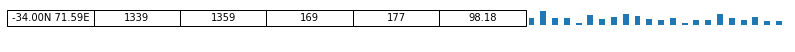

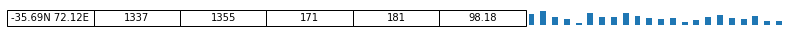

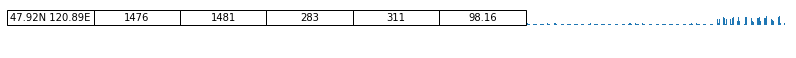

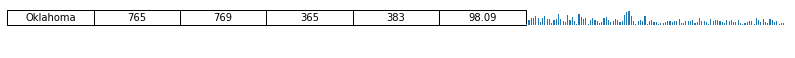

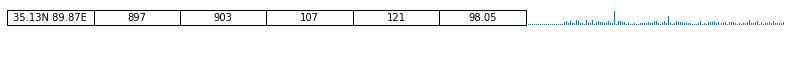

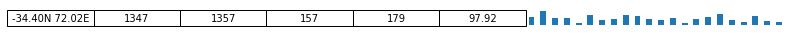

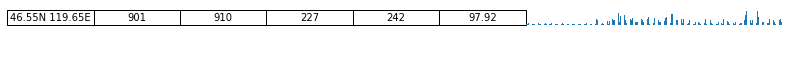

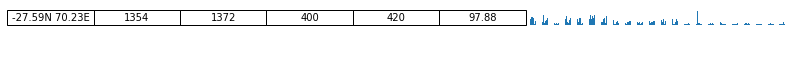

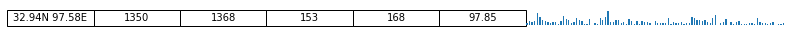

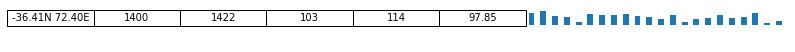

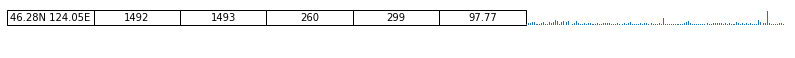

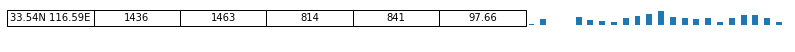

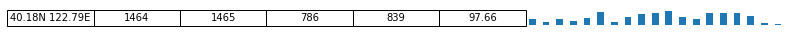

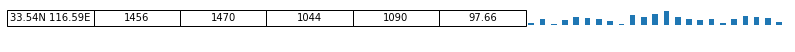

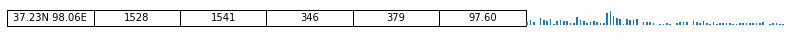

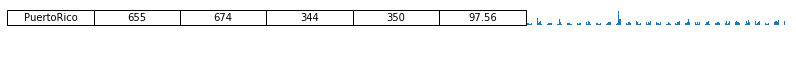

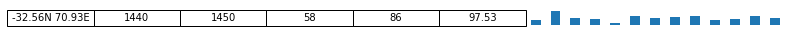

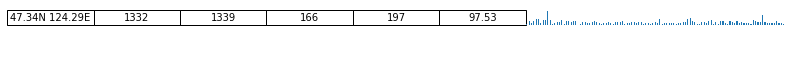

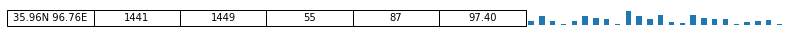

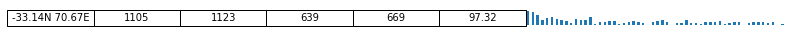

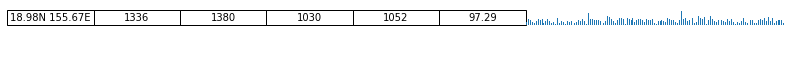

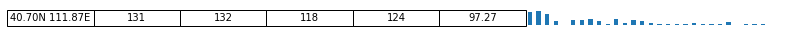

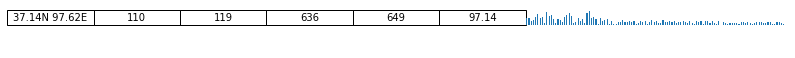

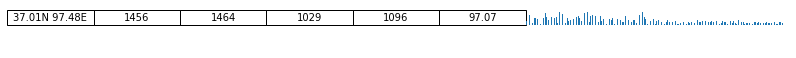

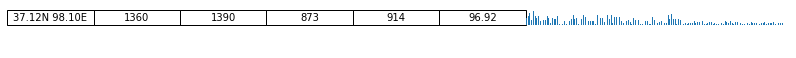

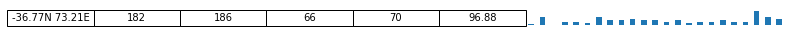

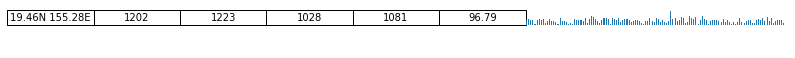

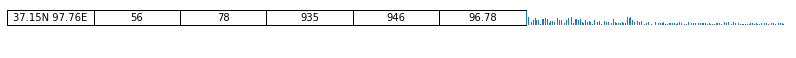

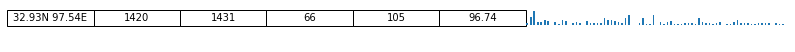

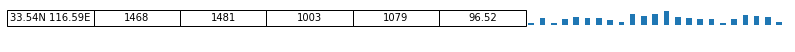

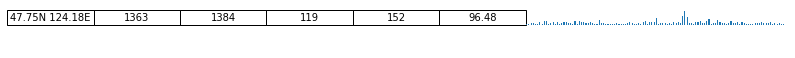

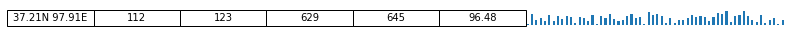

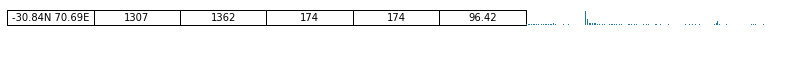

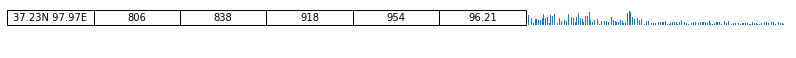

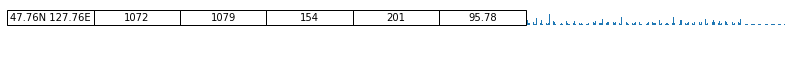

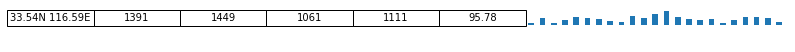

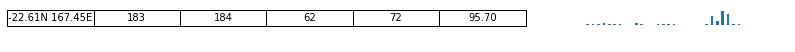

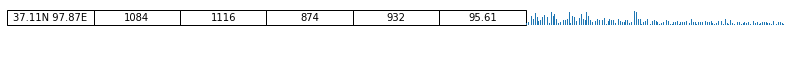

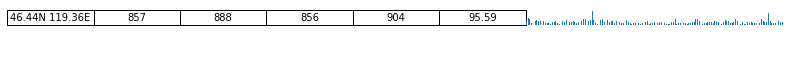

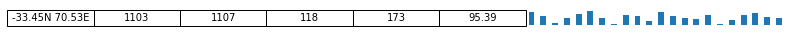

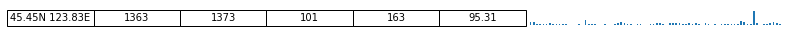

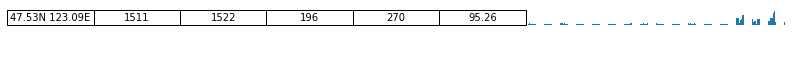

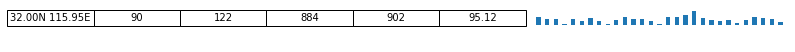

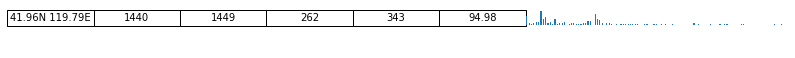

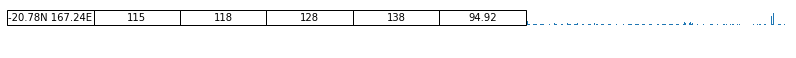

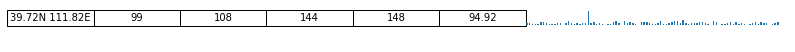

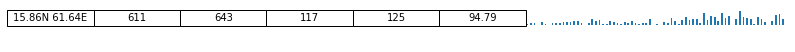

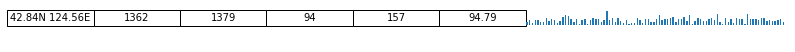

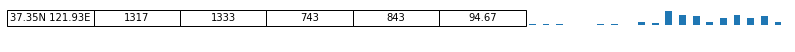

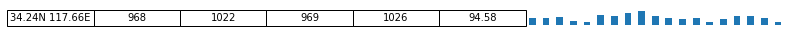

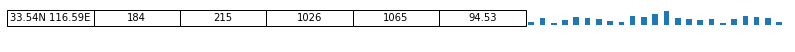

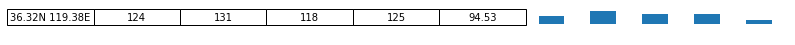

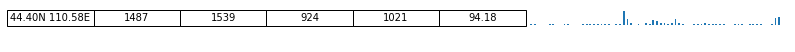

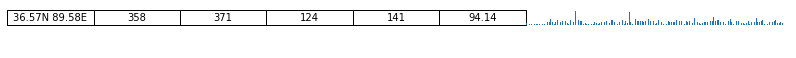

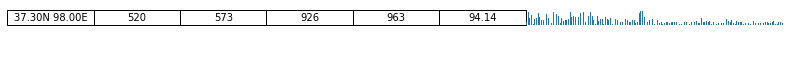

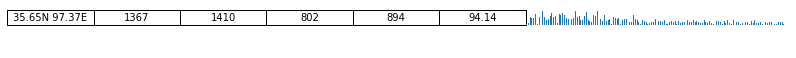

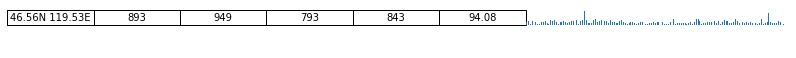

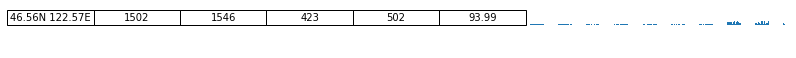

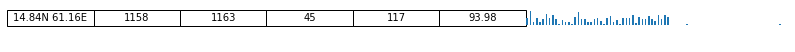

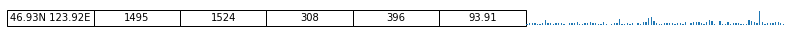

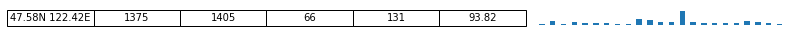

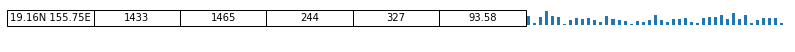

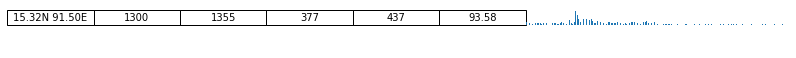

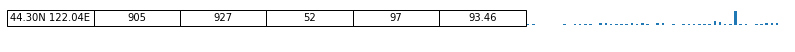

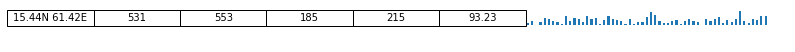

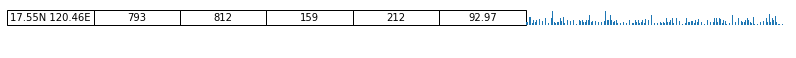

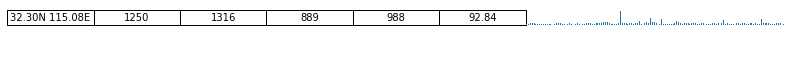

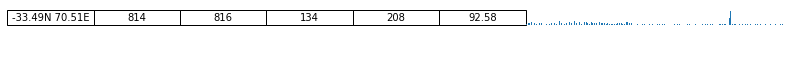

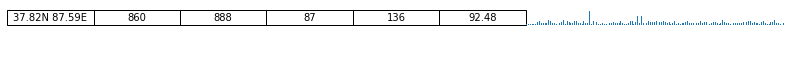

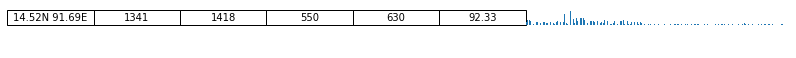

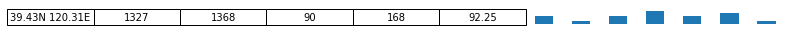

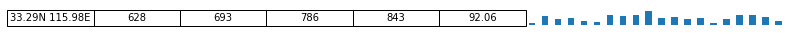

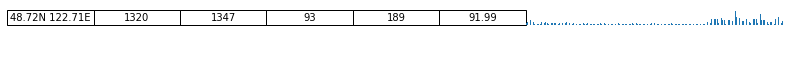

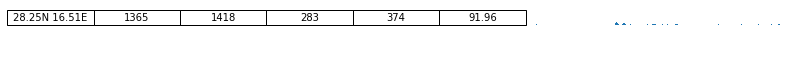

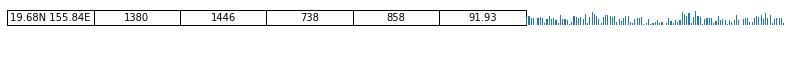

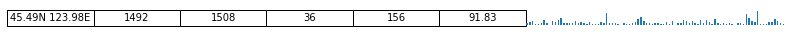

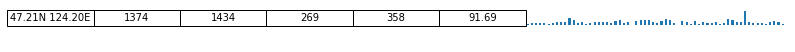

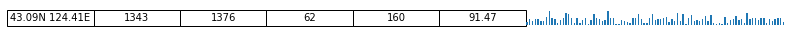

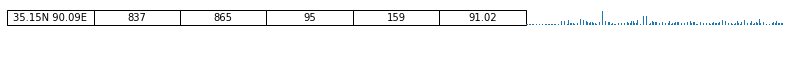

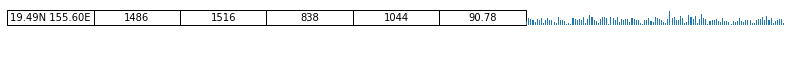

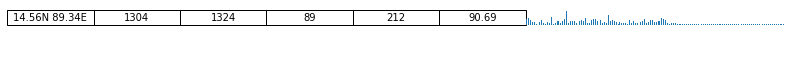

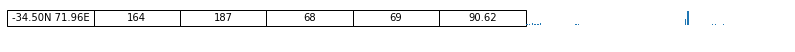

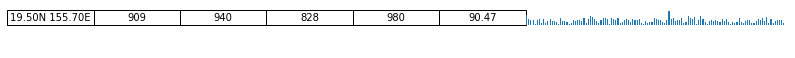

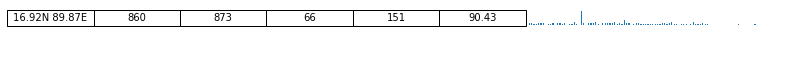

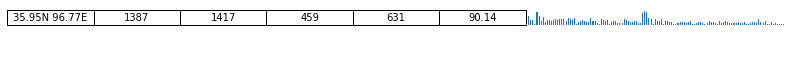

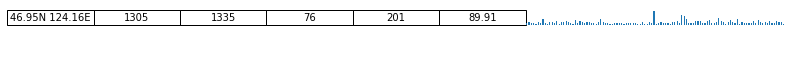

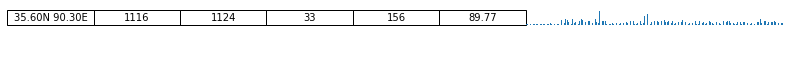

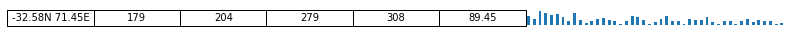

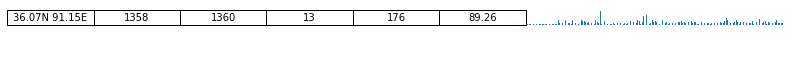

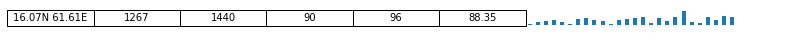

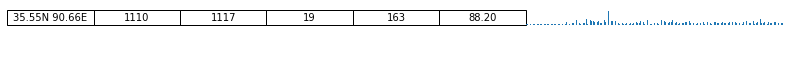

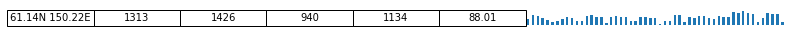

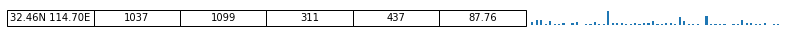

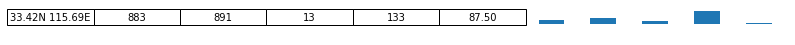

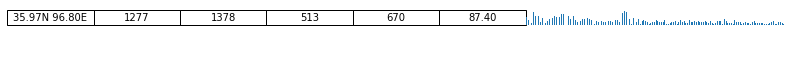

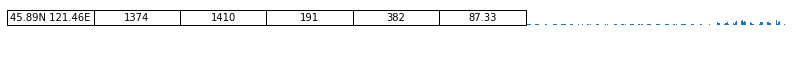

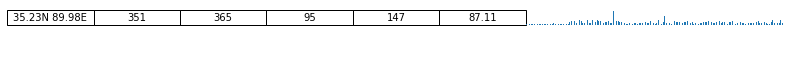

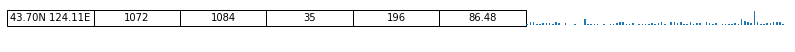

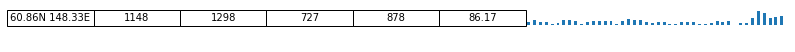

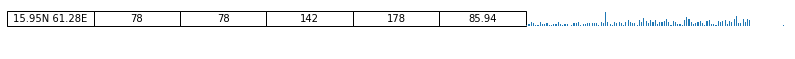

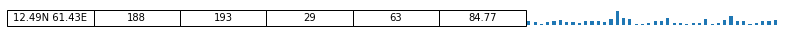

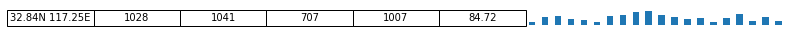

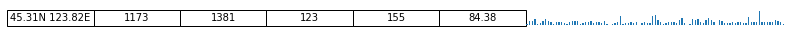

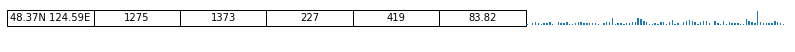

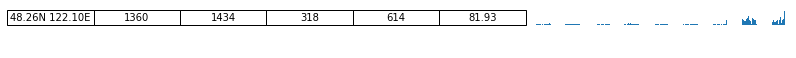

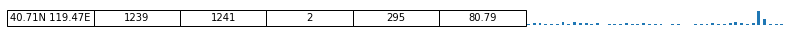

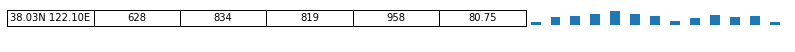

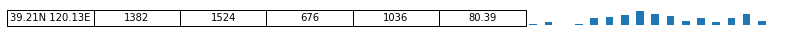

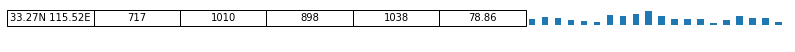

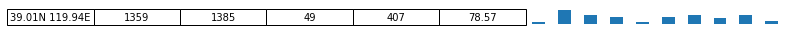

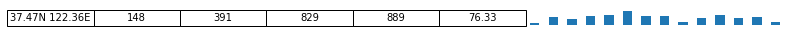

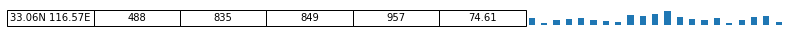

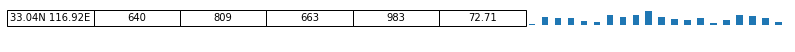

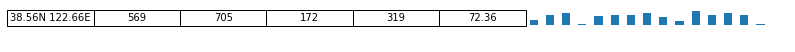

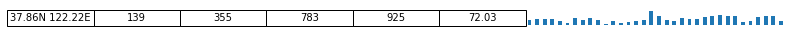

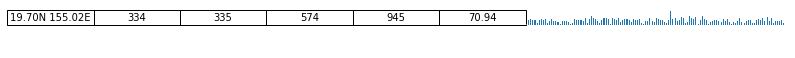

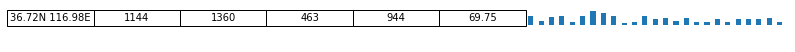

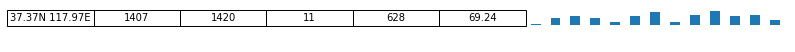

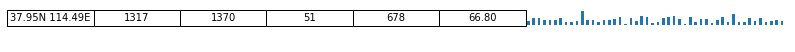

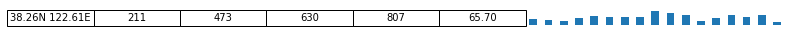

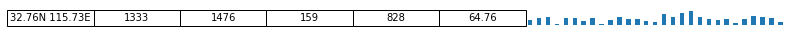

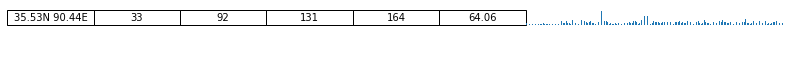

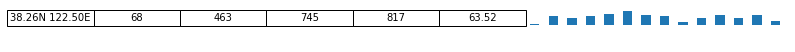

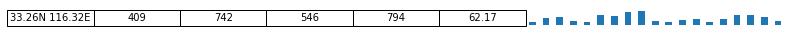

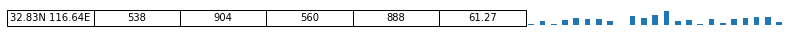

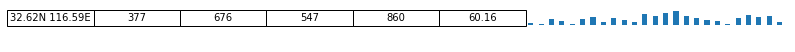

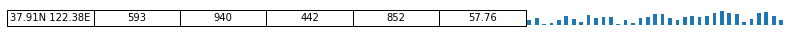

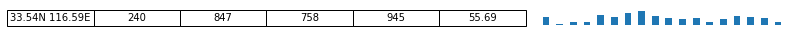

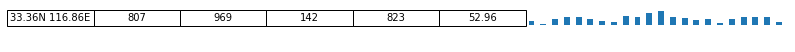

In [243]:
from IPython.display import display
from os.path import join as pj

figures_path = 'figures'

def plot_info_times(info, times, name, collabels=False):
    plot_time_freq(times, by='week', figsize=(12, 1), kind='bar', axis_on=False)     
    plot_info_table(info, collabels=collabels, scale=(2, 5), position='left')

    plt.subplots_adjust(left=.3, bottom=.4, right=.6, top=.6, wspace=0.01, hspace=0.01)
    plt.savefig(f"figures/{name}.png", bbox_inches='tight')

# Header
# info, times = infotimes[0]
# plot_info_times(info, times, 'header', collabels=True)

for i, (info, times) in enumerate(infotimes):
    try:
        plot_info_times(info, times, i)
    except TypeError:
        pass

In [245]:
figures = glob.glob(pj(figures_path, '*'))
header = figures.pop(figures.index('figures/header-good.png'))
def figure_num(figure):
    base = os.path.basename(figure)
    return int(base.split('.')[0])

figures = [header] + sorted(figures, key=figure_num)

In [246]:
for path in figures:
    remove_borders(path)

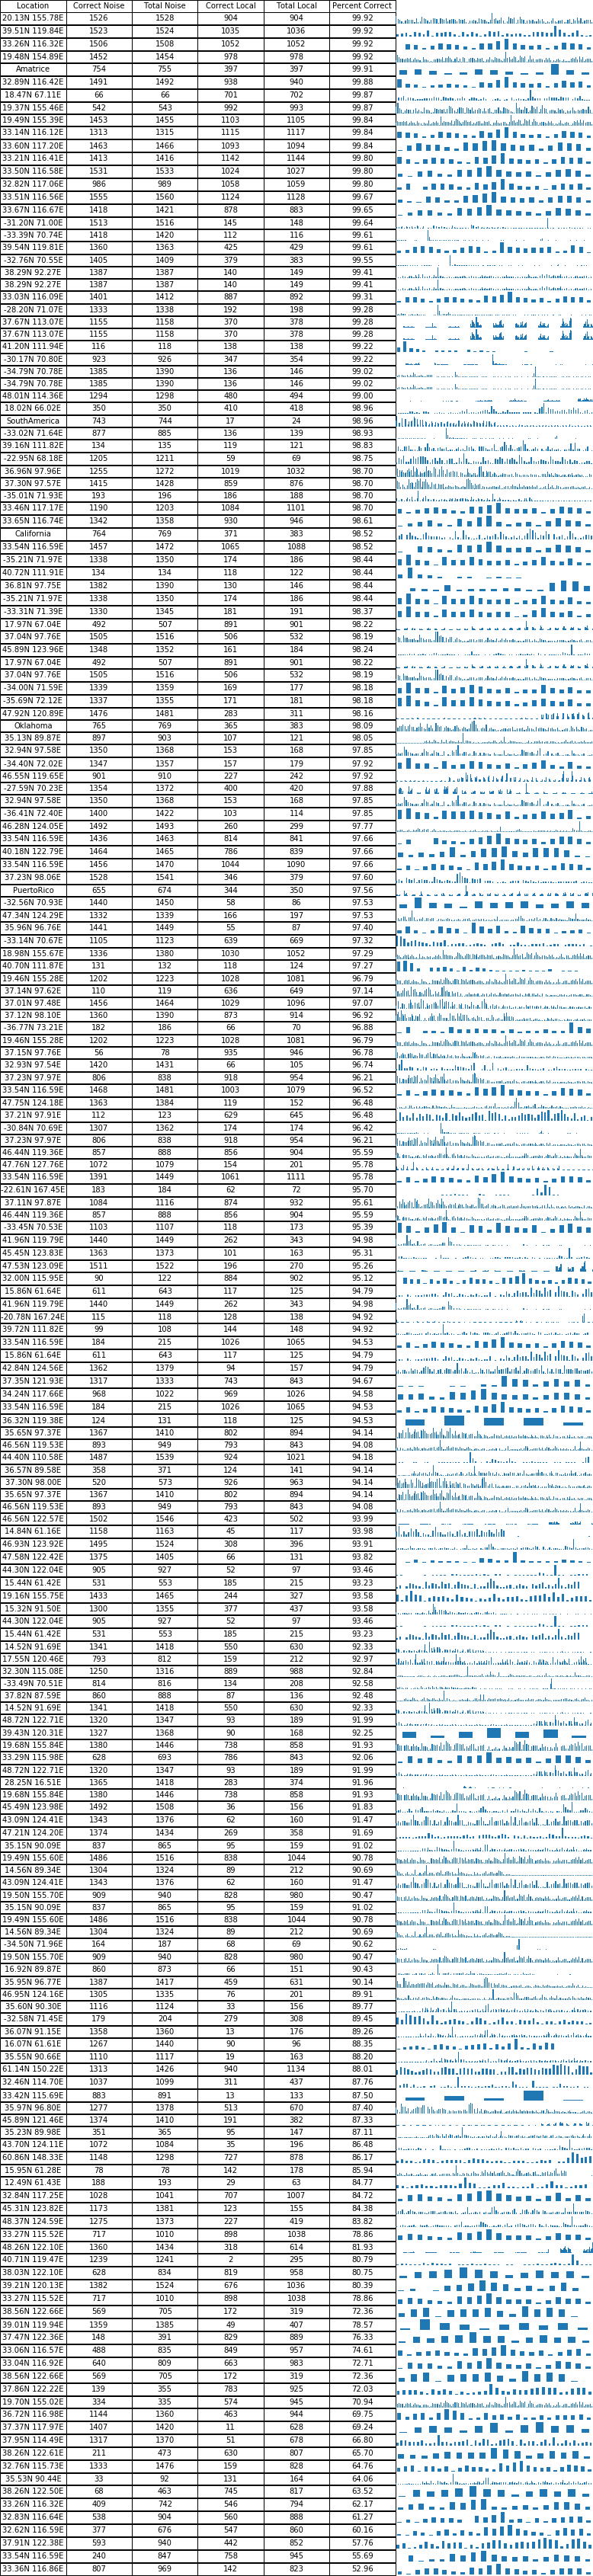

In [247]:
import io
from PIL import Image
import PIL

def figure_to_image(figure):
    buf = io.BytesIO()
    figure.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)
    return img

def combine_images_vertical(images):
    widths, heights = zip(*(i.size for i in images))
    max_width = max(widths)
    total_height = sum(heights)

    image = Image.new('RGB', (max_width, total_height), color='#FFFFFF')
    y_offset = 0

    for im in images:
        width, height = im.size
        image.paste(im, (0, y_offset))
        y_offset += height

    return image


def resize_image(image):
    return image.resize((1550, 33))

images = map(PIL.Image.open, figures)
images = list(images)

image = combine_images_vertical(images)
image.save('table.png')
image

# Next Section

In [214]:
# Load CSV

csv = '/home/audretj/developer-projects/waveforms/notebooks/combine-csv/cv-results.csv'
inform = pd.read_csv(csv)
inform = fix_column_names(clean(inform))
inform['Percent Correct'] = inform['Percent Correct'].apply(to_percent)

def prop_name(name):
    try:
        return proper_name(name)
    except ValueError:
        return name

inform['Location'] = inform['Location'].apply(prop_name)
inform = inform.sort_values(by='Percent Correct', ascending=False)

int_cols = ['Correct Noise', 'Total Noise',  'Correct Local', 'Total Local']
for col in int_cols:
    inform[col] = inform[col].apply(int)

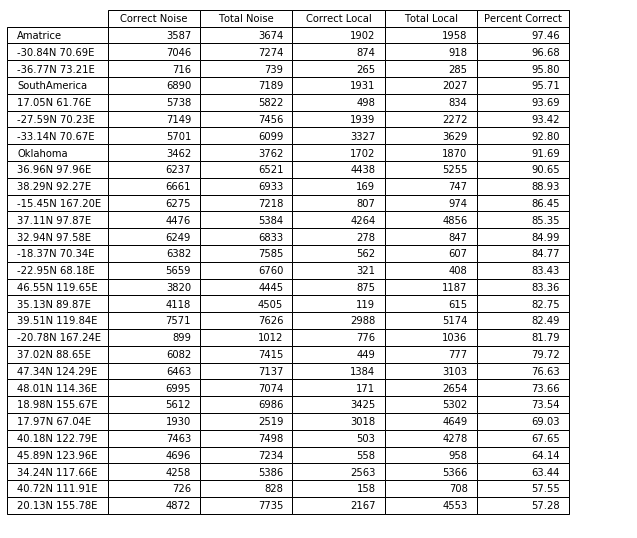

In [244]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


# Figure
fig, axs = plt.subplots(1, 1, figsize=(8, 7))
axs = [axs]
fig.subplots_adjust(wspace=0, top=1, right=1, left=0, bottom=0)
axs[0].axis('off')

# Data
row_labels = inform['Location'].values

_information = inform.drop('Location', 1)
column_labels = _information.columns.values

cell_text = _information.values
convert = lambda row: list(map(int, row[:4])) + [f'{row[4]:.2f}']
cell_text = [convert(row) for row in cell_text]

the_table = axs[0].table(cellText=cell_text,
                     rowLabels=row_labels,
                     colLabels=column_labels,
                     bbox=[0.1, 0.0, 0.8, 1.0])

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(2, 1)
axs[0].plot()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f824bf542b0>]],
      dtype=object)

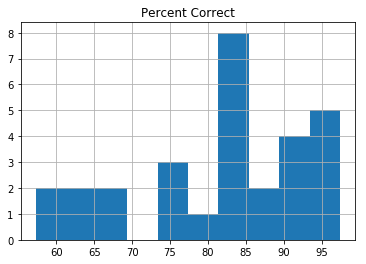

In [213]:
inform.hist(column='Percent Correct', bins=10)